# Task 1: conformational relationships within a single ensemble

Relationships within an ensemble will be identified considering the structural features of single
conformations

### 0. Set-up

In [1]:
import numpy as np
from Bio.PDB import PDBList, Superimposer, is_aa
from Bio.PDB.PDBParser import PDBParser
import requests
import math
import matplotlib.pyplot as plt

In [2]:
feature_folder = "./features/"
dist_mat_folder = feature_folder + "distance_matrices/"

### 1. Load PDB structures of one single PED ensemble

Download PED ensembles

In [3]:
ped_id = "PED00153"
url = "https://proteinensemble.org/api/" + ped_id
resp_json = requests.get(url).json()
print(resp_json["title"])
ensembles_ids = []
for curr_ensemble in resp_json["ensembles"]:
    ensembles_ids.append(curr_ensemble["ensemble_id"])

# get direct link to the downloadable file (url as string)
url = "https://proteinensemble.org/api/download"
parameters = {
   "ensemble_id": ensembles_ids
}
download_link = requests.get(url, params=parameters).text
resp_file = requests.get(download_link.replace('"', ''))

# download ensembles
with open("data/" + ped_id + ".tar", "wb") as f:
    f.write(resp_file.content)
  

Structure and dynamics of the MKK7


Extract compressed files

In [4]:
tar_to_extract = "./data/" + ped_id + ".tar"
data_folder = "./data/"

In [5]:
!tar -xzvf $tar_to_extract -C $data_folder

x PED00153e007.pdb.tar.gz
x PED00153e008.pdb.tar.gz
x PED00153e009.pdb.tar.gz
x PED00153e010.pdb.tar.gz
x PED00153e011.pdb.tar.gz


In [6]:
for ensemble in ensembles_ids:
    tar_to_extract = "./data/" + ensemble + ".pdb.tar.gz"
    !tar -xzvf $tar_to_extract -C $data_folder

x PED00153e007.pdb
x PED00153e008.pdb
x PED00153e009.pdb
x PED00153e010.pdb
x PED00153e011.pdb


Select the first ensemble and retrieve number of conformations and residues

In [7]:
ensemble_id = ensembles_ids[0]
ensemble = PDBParser(QUIET=True).get_structure(ensembles_ids[0], "data/{}.pdb".format(ensemble_id))

In [8]:
M = len(ensemble)
N = 0

In [9]:
structure_0 = ensemble[0]
for chain in structure_0:
    for residue in chain:
        if is_aa(residue):  # Filter hetero groups (returns only amino acids)
                # residue.id tuple contains hetero_flag, position, insertion_code
                # print("model {} chain {} residue_id {} resname {} resname_3to1 {}".format(model.id, chain.id, residue.id, residue.get_resname(),
                #                                        IUPACData.protein_letters_3to1.get(residue.get_resname().capitalize())))
            N+=1
            #for atom in residue:
                #print("atom {} {} {}".format(atom.id, atom.get_bfactor(), atom.get_coord()))
        else:
            print(residue.id)

In [10]:
print("Number of residues in one conformation: " + str(N))
print("Number of conformations in one ensemble: " + str(M))

Number of residues in one conformation: 100
Number of conformations in one ensemble: 200


### 2. Feature extraction
In the following we summarize the single conformation features that we are going to compute

* Single conformation features

| Feature       | Dimension     |
| :------------- |:-------------|
| Radius of gyration of the structure | Scalar |
| Relative accessible surface area (ASA) for each residue | Vector of size $N$      |
| Secondary structure (SS) for each residue and class | Vector of size $N$       |
|Residue distance matrix considering Cα atoms | Matrix of shape $N \times N$ (symmetric) |

where $N$ is the number of residues in one conformation.

* Ensembles features (multiple conformations)

| Feature       | Dimension     |
| :------------- |:-------------|
| Radius of gyration for each conformation in the ensemble | Vector of size $M$ |
| Secondary structure entropy for each position across ensemble conformations | Vector of size $N$      |
| Median solvent accessibility for each position across ensemble conformations | Vector of size $N$       |
| Median RMSD for each position across ensemble conformations | Vector of size $N$ |
| Median distance of each pair of equivalent positions across ensemble conformations | Matrix of shape $N \times N$ (symmetric) |
|Standard deviation of the distance of each pair of equivalent positions across ensemble conformations|Matrix of shape $N \times N$ (symmetric) |

where $N$ is the number of residues in one conformation and $M$ is the number of conformations in one ensemble.

* Claudia --> 1, 4
* Matteo --> 2
* Leonardo --> 3

Leggere un po Lazar.

#### Radius of gyration

In [11]:
def radius_gyration(chain):
    '''
    Calculates the Radius of Gyration (Rg) of a protein in Angstroms.
    Does not use mass and assume heavy atoms have the same mass.

    https://en.wikipedia.org/wiki/Radius_of_gyration  (formula considering mass)
    https://link.springer.com/article/10.1134/S0026893308040195  (formula without mass)
    '''

    # Heavy atoms coordinates
    coord = list()
    for atom in chain.get_atoms():
        if atom.get_name()[0] in ['C', 'O', 'N', 'S']:
            coord.append(atom.get_coord())
    coord = np.array(coord)  # N X 3

    barycenter = np.sum(coord, axis=0) / coord.shape[0]  # center of mass is more correct

    # Calculate distance of each atom from the barycenter
    dist = coord - barycenter
    dist = dist * dist
    dist = np.sqrt(np.sum(dist, axis=1))
    #print(dist)

    return round(math.sqrt(np.sum(dist * dist) / len(coord)), 3)

In [12]:
print("Radius of gyration of the first structure: %.2f" % radius_gyration(structure_0))

Radius of gyration of the first structure: 34.18


In [13]:
RG = np.zeros(M)
for i in range(M):
    RG[i]= radius_gyration(ensemble[i])

In [14]:
np.save(feature_folder + "radius_gyration.npy", RG)

#### Residue distance matrix considering Cα atoms

In [15]:
def get_distance_matrix(residues, seq_sep=6):

    # Calculate the distance matrix
    distances = []
    for residue1 in residues:
        if residue1.id[0] == " ":  # Exclude hetero/water residues
            row = []
            for residue2 in residues:
                if residue2.id[0] == " ":  # Exclude hetero/water residues
                    if abs(residue1.id[1] - residue2.id[1]) >= seq_sep:
                        row.append(residue1["CA"] - residue2["CA"])
                    else:
                        row.append(None)
            distances.append(row)

    return np.array(distances, dtype=float)

In [16]:
sequence_separation = 0
distance_matrices = []
for i in range(M): 
    dist_matrix = get_distance_matrix(ensemble[i]['A'], sequence_separation)
    distance_matrices.append(dist_matrix)
    np.save(dist_mat_folder + ensemble_id + "_" + str(i) + ".npy", dist_matrix)

#### Median distance of each pair of equivalent positions across ensemble conformations.

In [17]:
med_distance = np.zeros((N,N))
for i in range(N): #for 
    for j in range(N):#for every conformation
        distances = []
        for k in range(M):
            distances.append(distance_matrices[k][i,j])
        med_distance[i,j] = np.median(distances)

In [18]:
np.save(feature_folder + "median_distance.npy", med_distance)

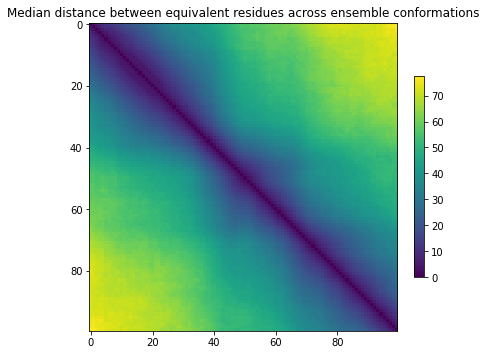

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(med_distance)
fig.colorbar(im, fraction=0.03, pad=0.05)
plt.title("Median distance between equivalent residues across ensemble conformations")
plt.show()

#### Standard deviation of the distance of each pair of equivalent positions across ensemble conformations

In [20]:
stdev_distance = np.zeros((N,N))
for i in range(N): #for 
    for j in range(N):#for every conformation
        distances = []
        for k in range(M):
            distances.append(distance_matrices[k][i,j])
        stdev_distance[i,j] = np.std(distances)

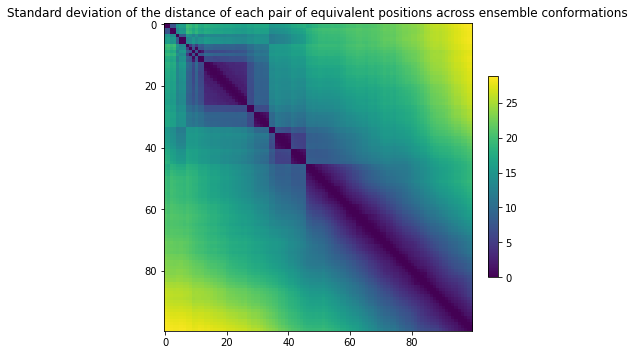

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(stdev_distance)
fig.colorbar(im, fraction=0.03, pad=0.05)
plt.title("Standard deviation of the distance of each pair of equivalent positions across ensemble conformations")
plt.show()

In [22]:
np.save(feature_folder + "stdev_distance.npy", stdev_distance)

#### Median RMSD for each position across ensemble conformations 1.

In [76]:
# Superimpose all models to the first model, fragment-by-fragment (sliding window)
super_imposer = Superimposer()
structure_rmsd_fragments = []  # RMSD, no_models X no_fragments X fragment_size
window_size = 5
ref_model = [atom for atom in ensemble[0].get_atoms() if atom.get_name() == "CA"]  # CA of the first model

In [77]:
# Iterate all models
for i, model in enumerate(ensemble):
    if i > 0:
        model_rmsd = []  # RMSD, no_fragment X fragment_size
        alt_model = [atom for atom in model.get_atoms() if atom.get_name() == "CA"]  # coords of the model

        # Iterate fragments
        for start in range(len(ref_model) - window_size):
            end = start + window_size
            ref_fragment = ref_model[start:end]
            alt_fragment = alt_model[start:end]

            # Calculate rotation/translation matrices
            super_imposer.set_atoms(ref_fragment, alt_fragment)
            # print(super_imposer.rms, super_imposer.rotran)

            # Rotate-translate coordinates
            alt_fragment_coord = np.array([atom.get_coord() for atom in alt_fragment])
            alt_fragment_coord = np.dot(super_imposer.rotran[0].T, alt_fragment_coord.T).T
            alt_fragment_coord = alt_fragment_coord + super_imposer.rotran[1]

            # Calculate RMSD
            # https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions
            ref_fragment_coord = np.array([atom.get_coord() for atom in ref_fragment])
            dist = ref_fragment_coord - alt_fragment_coord
            # rmsd_fragment = np.sqrt(np.sum(dist * dist) / window_size)  # Total RMSD of the fragment. Identical to super_imposer.rms
            rmsd_res = np.sqrt(np.sum(dist * dist, axis=1))  # RMSD for each residue of the fragment

            model_rmsd.append(rmsd_res)

        structure_rmsd_fragments.append(model_rmsd)

In [78]:
# Calculate average RMSD per position
structure_rmsd_fragments = np.array(structure_rmsd_fragments)  # no_models X no_fragments X fragment_size
# Calculate the RMSD average for each fragments along all models
structure_rmsd_fragments = np.average(structure_rmsd_fragments, axis=0)  # no_fragments X fragment_size

In [79]:
# Pad with right zeros to reach the sequence length (no_fragments + fragment_size)
structure_rmsd_fragments = np.pad(structure_rmsd_fragments, ((0, 0), (0, structure_rmsd_fragments.shape[0])))
print(structure_rmsd_fragments.shape)

(95, 100)


In [83]:
# Roll the fragments one by one (add heading zeros)
for i, row in enumerate(structure_rmsd_fragments):
    structure_rmsd_fragments[i] = np.roll(row, i)
print(structure_rmsd_fragments)

[[1.85823796 1.97971182 2.3327567  ... 0.         0.         0.        ]
 [0.         2.46020726 1.95564581 ... 0.         0.         0.        ]
 [0.         0.         2.89527806 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.53973367 0.         0.        ]
 [0.         0.         0.         ... 1.80470413 1.61334661 0.        ]]


In [88]:
structure_rmsd_fragments[94]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [91]:
# Calculate average along columns of overlapping fragments (average RMSD per residue)
structure_rmsd_median = np.median(structure_rmsd_fragments, axis=0)

In [92]:
structure_rmsd_median

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### 3. Graph extraction
Nodes are a subset of representative conformations and edges represent their similarity (or distance). The similarity is calculated combining all feature values. Representative conformations are found by unsupervised
clustering and the number of clusters is identified automatically.

### 4. Pymol image
An Pymol image including the PDB structures corresponding to the graph nodes.
Centered (translate) the selected structures on the position(s) with the lowest feature
variance. Residues in each structure will be displayed (color, size, ...) based on their
feature variability within the ensemble.